In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [3]:
conf = SparkConf().set("spark.ui.port", "4050")

# creamos el contexto y la sesión
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at /tmp/ipykernel_14/2463471719.py:4 

In [4]:
data_covid = sc.textFile('./data/covid_articles_raw.csv')

In [5]:
type(data_covid)

pyspark.rdd.RDD

In [26]:
data_covid.take(50)

['titlecontentcategory',
 'looking into the truth about modern workplace environmentshi what are you looking for',
 'by',
 'published',
 'workplaces are being transformed according to the olivet nazarene university study   the truth about modern offices  the days of men and women fitted in formal clothing and working under the harsh glare fluorescent lighting are slipping away the trends of today are reflective of casual dress codes and soft furnishings',
 'there are signs too that the ‘ animal penning’  read cubicles are starting to be withdrawn and replaced with open floor plans  indications are that over half of workplaces – 51 percent – have gravitated towards the ‘ open office’ or open floor plan concept',
 'the survey also showed that 77 percent of us located workers are reportedly happy with the way their office is set up however as an indication of thoughts about openplan areas those with private offices stated they were happiest',
 'through changing technology more employees a

### Creamos una función que "limpia" cada línea: se remueven signos de puntuación y otros caracteres. Adicionalmente convertimos el texto a minúscula

In [7]:
def clean_text(line:str) -> str:
    punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~-“”'
    words = ['covid 19','covid19', 'covid19 ', ' covid19', 'said','2020','2021','coronavirus','pandemic']
    lowercased = line.lower()
    for word in words:
        lowercased = lowercased.replace(word, '')
    return lowercased.translate(str.maketrans('','',punct)).strip()

In [8]:
data_covid = data_covid.map(clean_text)

In [9]:
data_covid.take(10)

['titlecontentcategory',
 'looking into the truth about modern workplace environmentshi what are you looking for',
 'by',
 'published',
 'workplaces are being transformed according to the olivet nazarene university study   the truth about modern offices  the days of men and women fitted in formal clothing and working under the harsh glare fluorescent lighting are slipping away the trends of today are reflective of casual dress codes and soft furnishings',
 'there are signs too that the ‘ animal penning’  read cubicles are starting to be withdrawn and replaced with open floor plans  indications are that over half of workplaces – 51 percent – have gravitated towards the ‘ open office’ or open floor plan concept',
 'the survey also showed that 77 percent of us located workers are reportedly happy with the way their office is set up however as an indication of thoughts about openplan areas those with private offices stated they were happiest',
 'through changing technology more employees a

In [10]:
all_words = data_covid.flatMap(lambda line: line.split())

In [11]:
all_words.take(20)

['titlecontentcategory',
 'looking',
 'into',
 'the',
 'truth',
 'about',
 'modern',
 'workplace',
 'environmentshi',
 'what',
 'are',
 'you',
 'looking',
 'for',
 'by',
 'published',
 'workplaces',
 'are',
 'being',
 'transformed']

In [12]:
data_covid_count = all_words.map(lambda word: (word,1))

In [25]:
all_words.count()

415973939

In [13]:
data_covid_rbk = data_covid_count.reduceByKey(lambda a,b: a+b).sortByKey()

In [14]:
data_covid_rbk.persist()

PythonRDD[15] at RDD at PythonRDD.scala:53

In [15]:
data_covid_rbk.take(10)

[('\x02betacyclodextrinsfunctionalized', 1),
 ('\x07easy', 1),
 ('\x07global', 2),
 ('\x07good', 1),
 ('\x08hortaosório', 1),
 ('0', 36241),
 ('00', 6593),
 ('000', 15865),
 ('0000', 281),
 ('00000', 36)]

### Truco para encontrar las palabras con mas ocurrencias:

In [16]:
import nltk

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Dejamos solo las palabras que no sean stopwords

In [19]:
data_covid_rbk = data_covid_rbk.filter(lambda tupla: tupla[0] not in stopwords)

In [20]:
data_covid_rbk.map(lambda tupla: (tupla[1],tupla[0])).sortByKey(False).take(20)

[(989367, 'us'),
 (961651, 'new'),
 (910157, 'covid19'),
 (856812, 'also'),
 (847827, 'people'),
 (762879, 'market'),
 (701859, 'million'),
 (690674, 'year'),
 (642729, 'one'),
 (618743, 'would'),
 (569640, 'may'),
 (563166, 'health'),
 (561388, 'company'),
 (552042, 'time'),
 (547136, 'first'),
 (514243, 'could'),
 (507843, 'business'),
 (453141, 'like'),
 (445763, 'data'),
 (444302, '—')]

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [22]:
word_dict = {tupla[0]:float(tupla[1]) for tupla in data_covid_rbk.collect()}

In [23]:
wc = WordCloud(width=3000,height=1000).generate_from_frequencies(word_dict)

(-0.5, 2999.5, 999.5, -0.5)

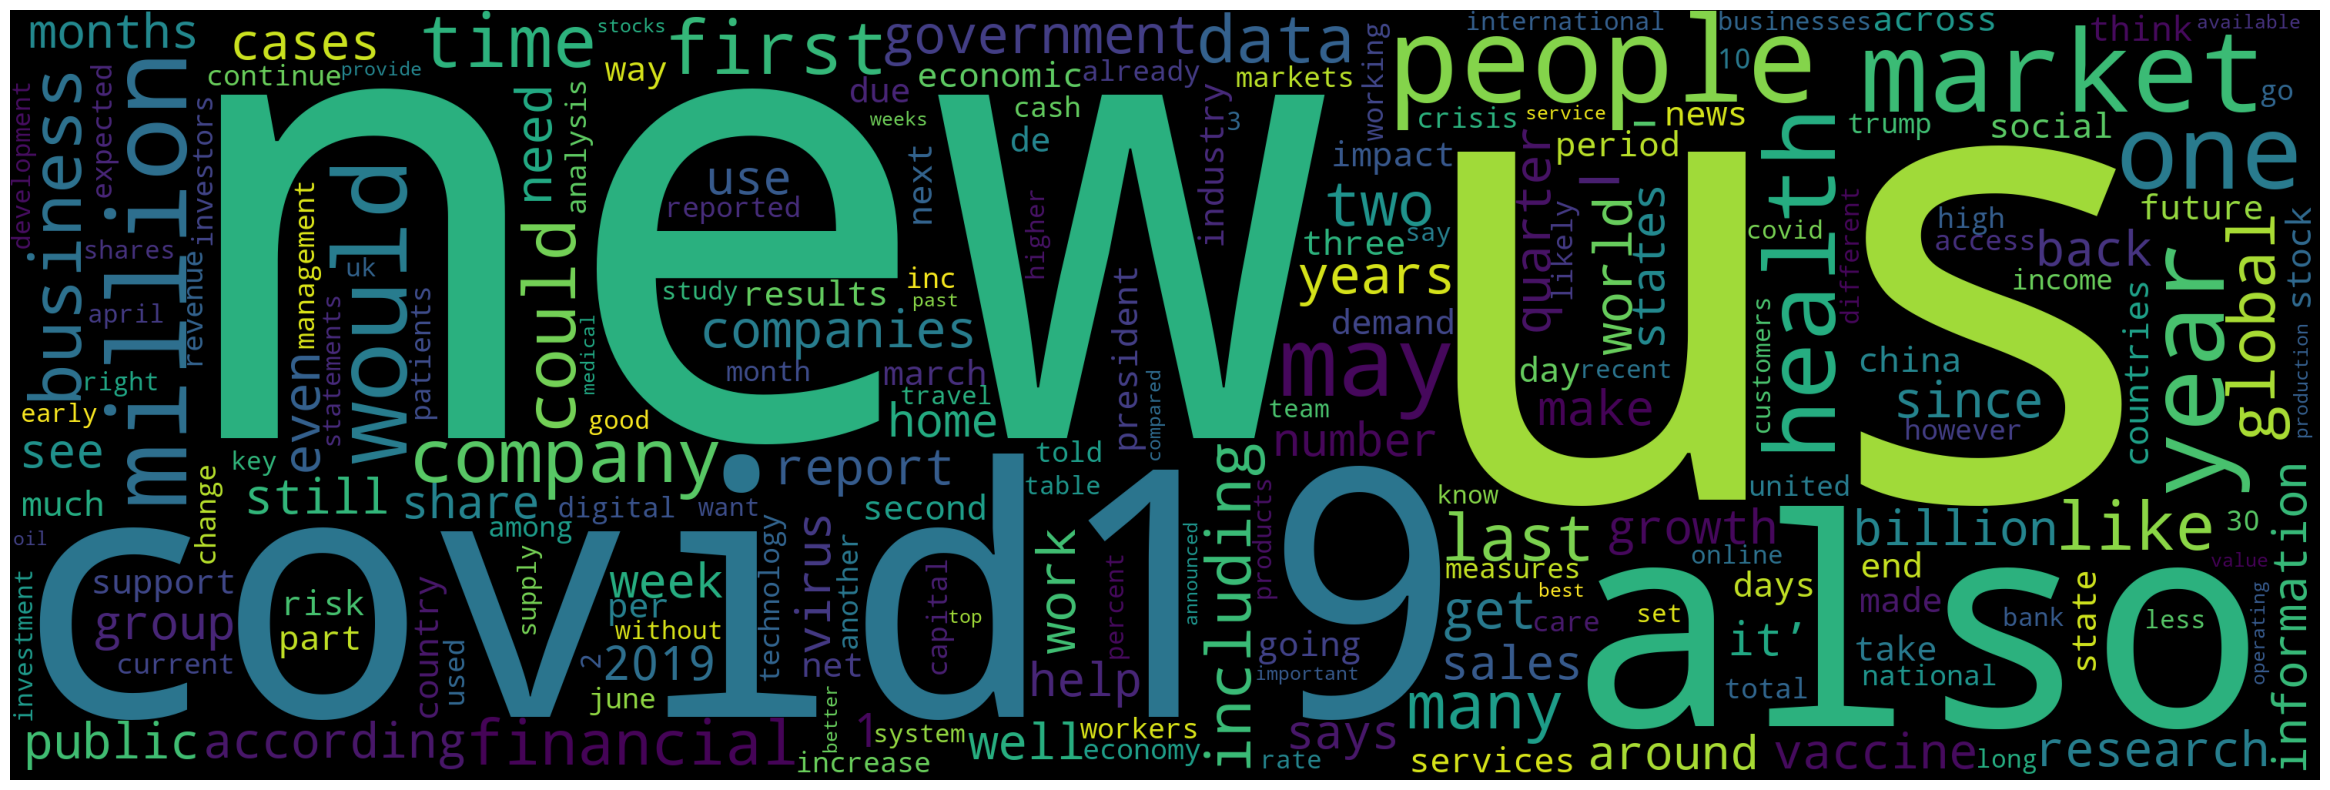

In [24]:
plt.figure(figsize=(30, 10))
plt.imshow(wc)
plt.axis("off")